#ART-DNA project: art styles prediction with CNN and transfer learning

### 0.0 Imports and Drive

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential (only for CNN without transfer learning)
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Generating the dataset from images paths on Google Drive

### 1.1 Extracting artist names from image filenames

In [ ]:
images_root = '/content/drive/My Drive/art_dna/raw_data/resized'

In [ ]:
import re

def extract_artist_name_from_filename(filename):
    match = re.match(r"([A-Za-z_]+)_\d+\.jpg", filename)
    if match:
        return match.group(1).replace("_", " ")
    return None


def create_image_artist_df(images_root):
    data = []
    for root, _, files in os.walk(images_root):
        for file in files:
            if file.lower().endswith(".jpg"):
                artist_name = extract_artist_name_from_filename(file)
                rel_path = os.path.join(root, file)
                if artist_name:
                    data.append({"image_path": rel_path, "artist_name": artist_name})

    return pd.DataFrame(data)

In [ ]:
df = create_image_artist_df(images_root)
df.head()

,image_path,artist_name
0,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee
1,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee
2,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee
3,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee
4,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee


In [ ]:
artists_metadata = pd.read_csv('/content/drive/My Drive/art_dna/raw_data/artists.csv')

In [ ]:
artists_metadata.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


### 1.2 Encoding and cleaning art styles in the merged dataframe

In [ ]:
genre_mapping = {
    "Social Realism,Muralism": "Realism,Muralism",
    "Post-Impressionism": "Impressionism",
    "Northern Renaissance": "Renaissance",
    "Proto Renaissance": "Renaissance",
    "Early Renaissance": "Renaissance",
    "High Renaissance": "Renaissance",
    "Impressionism,Post-Impressionism": "Impressionism",
    "High Renaissance,Mannerism": "Renaissance,Mannerism",
    "Symbolism,Post-Impressionism": "Symbolism,Impressionism",
    "Abstract Expressionism": "Expressionism"
}

In [ ]:
def simplify_genre(genre_string):
    return genre_mapping.get(genre_string, genre_string)

artists_metadata["genre_simplified"] = artists_metadata["genre"].apply(simplify_genre)

In [ ]:
Merge the dataframes on artist name
merged_df = pd.merge(df, artists_metadata[["name", "genre_simplified"]], left_on="artist_name", right_on="name", how="inner")

# Drop the redundant 'name' column
merged_df = merged_df.drop("name", axis=1)
merged_df.head()

,image_path,artist_name,genre_simplified
0,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,"Expressionism,Abstractionism,Surrealism"
1,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,"Expressionism,Abstractionism,Surrealism"
2,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,"Expressionism,Abstractionism,Surrealism"
3,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,"Expressionism,Abstractionism,Surrealism"
4,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,"Expressionism,Abstractionism,Surrealism"


In [ ]:
merged_genres = merged_df["genre_simplified"].apply(lambda x: [g.strip() for g in x.split(',') if g.strip()])

In [ ]:
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(merged_genres)
print(mlb.classes_)
print(len(mlb.classes_))

['Abstractionism' 'Art Nouveau' 'Baroque' 'Byzantine Art' 'Cubism'
 'Expressionism' 'Impressionism' 'Mannerism' 'Muralism' 'Neoplasticism'
 'Pop Art' 'Primitivism' 'Realism' 'Renaissance' 'Romanticism'
 'Suprematism' 'Surrealism' 'Symbolism']
18


### 1.3 Creating the final dataframe of image paths, artists, and encoded art styles

In [ ]:
# Create a dataframe from the encoded genres
genres_dataframe = pd.DataFrame(genres_encoded, columns=mlb.classes_)
genres_dataframe.head()

,Abstractionism,Art Nouveau,Baroque,Byzantine Art,Cubism,Expressionism,Impressionism,Mannerism,Muralism,Neoplasticism,Pop Art,Primitivism,Realism,Renaissance,Romanticism,Suprematism,Surrealism,Symbolism
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Concatenate the image path and artist name with the encoded genres
final_df = pd.concat([merged_df[["image_path", "artist_name"]], genres_dataframe], axis=1)

In [ ]:
# Check for NaN values after merging and encoding

print("Checking for NaN values in genre columns after merging:")
final_df.columns.isnull().sum()

final_df.head()

Checking for NaN values in genre columns after merging:
0


,image_path,artist_name,Abstractionism,Art Nouveau,Baroque,Byzantine Art,Cubism,Expressionism,Impressionism,Mannerism,Muralism,Neoplasticism,Pop Art,Primitivism,Realism,Renaissance,Romanticism,Suprematism,Surrealism,Symbolism
0,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#Save the result to CSV
final_df.to_csv('/content/drive/My Drive/art_dna/raw_data/final_df.csv',index=False)

## 2. Creating train and test sets

In [ ]:
final_df = pd.read_csv('/content/drive/My Drive/art_dna/raw_data/final_df.csv')
final_df.head()

,image_path,artist_name,Abstractionism,Art Nouveau,Baroque,Byzantine Art,Cubism,Expressionism,Impressionism,Mannerism,Muralism,Neoplasticism,Pop Art,Primitivism,Realism,Renaissance,Romanticism,Suprematism,Surrealism,Symbolism
0,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,/content/drive/My Drive/art_dna/raw_data/resiz...,Paul Klee,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
def process_image(file_path, label):
    # 1. Read the image file: tf.io.read_file reads the raw bytes of the image file from the given file_path.
    image = tf.io.read_file(file_path)

    # 2. Decode the JPEG image: tf.image.decode_jpeg decodes the raw bytes into a tensor representing the image. channels=3 specifies that we expect a color image (RGB).
    image = tf.image.decode_jpeg(image, channels=3)

    # 3. Resize the image: tf.image.resize resizes the image to a fixed size (224x224 in this case).
    #This is crucial because neural networks typically require fixed-size inputs.
    image = tf.image.resize(image, [224, 224])

    # 4. Return the processed image and its label:
    # The function returns the resized image tensor and the corresponding label (the one-hot encoded vector).
    return image, label

In [ ]:
# This function creates a TensorFlow Dataset from a DataFrame of image paths and labels

COLUMN_LABELS = final_df.columns[2:] # Corrected to select only genre columns

def create_dataset(df, batch_size=16, shuffle=True):

    # Extract image paths and labels from the DataFrame
    paths = df["image_path"].values  # List of image file paths
    labels = df[COLUMN_LABELS].values.astype("float32")  # Convert label columns to float32 for training

    # Create a dataset from the paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    # Apply the process_image function to load, resize, and normalize images, with parallel pre-loading
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Cache the dataset (in memory)
    dataset = dataset.cache()

    # If shuffle is True, shuffle the dataset (useful for training)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)  # 1000 is the size of the shuffle buffer

    # Group the data into batches (e.g., 16 images per batch)
    dataset = dataset.batch(batch_size)

    # Prefetch allows the next batch to be prepared while the current one is being processed
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # Return the final dataset, ready to be used in model training or validation
    return dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Update the train and test dataframes with the new dataframe
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)

# Split 30% of the train_df into validation
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=42)

# Smaller batch size for GPU-friendly training
BATCH_SIZE = 16  # try 8

#create datasets
train_dataset = create_dataset(train_df,batch_size=BATCH_SIZE)
val_dataset = create_dataset(val_df,batch_size=BATCH_SIZE,shuffle=False)
test_dataset = create_dataset(test_df, shuffle=False)  # Final test data

## 3. VGG16 model builduing, training, and finetuning

### 3.1 Creating class weights to counterbalance the dominance of the Impressionism class

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

#Number of output classes (multi-label)
num_styles = 18

# Extract label arrays from the train DataFrame
train_style_labels = train_df[COLUMN_LABELS].values

# Calculate class weights for each style (class) in the training set
class_weights = {}
for i in range(num_styles):
    class_weights[i] = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),  # Convert list to NumPy array
        y=train_style_labels[:, i]
    )

### 3.2 Creating a custom loss function that weights the binary crossentropy loss per class by the class weights computed above

In [ ]:
# Get positive class weights only (for label '1') per class
positive_class_weights = [class_weights[i][1] for i in range(num_styles)]

# Convert to tensor of shape (num_styles,)
weights_tensor = tf.constant(positive_class_weights, dtype=tf.float32)  # shape: (num_classes,)

def weighted_binary_crossentropy(y_true, y_pred):
    # Compute binary crossentropy per element (no reduction)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)  # shape: (batch_size, num_classes)

    # Reshape weights to enable broadcasting over batch dimension
    weights_expanded = tf.reshape(weights_tensor, (1, -1))  # shape: (1, num_classes)

    # Apply class weights
    weighted_bce = bce * weights_expanded  # shape: (batch_size, num_classes)

    # Average over classes per sample → shape: (batch_size,)
    loss_per_sample = tf.reduce_mean(weighted_bce, axis=-1)

    # Final loss: average over batch
    return tf.reduce_mean(loss_per_sample)

### 3.3. Setup of the MLflow logs

In [ ]:
%pip install -q dagshub 'mlflow>=2,<3'

In [ ]:
import dagshub
dagshub.init(repo_owner='kristina.kogan', repo_name='art-dna', mlflow=True)

Initialized MLflow to track repo "kristina.kogan/art-dna"

Repository kristina.kogan/art-dna initialized!

In [ ]:
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/kristina.kogan/art-dna.mlflow/")
mlflow.set_experiment("art_style_classifier")

<Experiment: artifact_location='mlflow-artifacts:/33edeba675ff4586aa524619530b20ab', creation_time=1753195387981, experiment_id='0', last_update_time=1753195387981, lifecycle_stage='active', name='art_style_classifier', tags={'mlflow.sharedViewState.708a1114b24a002c30d16fb2c025507a488df39fc39b6ac89eb70a913858374b': 'deflate;eJx9Ul1v2zAM/CuDnoOhfc2bG6RbsWQYnDYoEBSOItExB0oyRCmNV+S/l07cee2GPfJ4Rx4/XhSDjqa5RUoQ1VSpiQrRQrzpvkEnsYMU0fDn7UFTVV9Xz4D7JoHdjsSCjZrWmhgmipOO6R4diLRYLIREWIPpDMHvFoVJeABJWZ00Q+K3zOZpolywQGuIjMGPCqJPZfYsGgYCI/1ngbITZLpROonFXU4gLh8YYm/tf7bf5RrtHPp9RYH5r+RPbYyOtmITIvyrrEMTw1aJ7yj25sdWewtWTV9OF+QHet/Hm4HxFa0FP8ZrZNwhYeqWuh1lF9pSViHD396Vq/vq+qoqH76vxMMB4Xmpj+jwV196WLzIFsjprcGAIhdGvFtZZgnnc/0hyQxfYsgt2LWmDHznZ41cT3aaYpZ8gxbmrk3de3jfa27kN3wmGsIPo+ucQgl1BG7mXu+oxwcxhZ2mBXo4F50FX+NeROpYHJEvL8cJ2vPjeFi5EFLjgaX71Xj8x568PN/iIlGn0ysNKv+l'}>

### 3.4 Building and training

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1)
])

In [ ]:
#Creating a dictionary to track augmentation_info on MLFlow

augmentation_info = {
    "RandomFlip": "horizontal",
    "RandomRotation": "0.05",
    "RandomZoom": "0.1",
}

In [ ]:
# VGG16 base model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers initially

# Unfreeze last 4 convolutional layers for fine-tuning
for layer in base_model.layers[-4:]:
    if 'conv' in layer.name:
        layer.trainable = True

inputs = layers.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)  # data augmentation layers
x = preprocess_input(x)  # preprocessing for VGG16
x = base_model(x)  # VGG16 feature extractor

# Replace Flatten with GlobalAveragePooling2D to reduce parameters drastically
#x = layers.Flatten()(x)
x = layers.GlobalAveragePooling2D()(x)  # Reduces tensor size and parameters

# Custom dense layers after pooling
x = layers.Dense(64, activation="relu")(x)  # Reduced layer size to lower parameters
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation="relu")(x)  # Further reduce dense layer size
x = layers.Dropout(0.3)(x)

pred = layers.Dense(num_styles, activation="sigmoid")(x)  # Multi-label output layer

# Create the model
model_3 = Model(inputs=inputs, outputs=pred)

In [ ]:
model_3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     32,832 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 18)        │        594 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,750,194 (56.27 MB)

 Trainable params: 7,114,930 (27.14 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
#Uncomment to continue training the same model
#from tensorflow.keras.models import load_model

In [ ]:
#Uncomment and update path to continue training the same model
#model_3 = load_model("/content/drive/My Drive/art_dna/model_3.keras")

In [ ]:
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=weighted_binary_crossentropy,
    metrics=['accuracy']
)

In [ ]:
# Set checkpoint filepath
checkpoint_path = "/content/drive/My Drive/art_dna/model_3.keras"

modelCheckpoint = callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True
)

LRreducer = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=0
)

EarlyStopper = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    restore_best_weights=True
)

In [ ]:
import mlflow.tensorflow
import inspect
import os
import time

mlflow.tensorflow.autolog()

with mlflow.start_run(run_name="model_3"):

    # Log additional parameters
    for augmentation, param in augmentation_info.items():
        mlflow.log_param(f"augmentation_{augmentation}", param)

    mlflow.log_param("batch_size", BATCH_SIZE)

    # Log custom loss function as an artifact
    loss_function_code = inspect.getsource(weighted_binary_crossentropy)
    with open("weighted_binary_crossentropy.py", "w") as f:
        f.write(loss_function_code)
    mlflow.log_artifact("weighted_binary_crossentropy.py")
    os.remove("weighted_binary_crossentropy.py")  # Clean up the created file

    # Measure training time manually
    start_time = time.time()

    history = model_3.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        callbacks=[modelCheckpoint, LRreducer, EarlyStopper]
    )

    end_time = time.time()
    training_duration = end_time - start_time
    mlflow.log_metric("training_time_seconds", training_duration)

    # Log on MLflow metrics from last epoch
    final_train_acc = history.history["accuracy"][-1]
    final_val_acc = history.history["val_accuracy"][-1]

    mlflow.log_metric("train_accuracy", final_train_acc)
    mlflow.log_metric("val_accuracy", final_val_acc)

    # Save model and log it as artifact
    model_3.save("model_3.keras")
    mlflow.log_artifact("model_3.keras")

Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 1087s 4s/step - accuracy: 0.1118 - loss: 10.0528 - val_accuracy: 0.1248 - val_loss: 3.4667 - learning_rate: 1.0000e-04
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.1398 - loss: 5.0811 - val_accuracy: 0.1248 - val_loss: 2.4199 - learning_rate: 1.0000e-04
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 34s 127ms/step - accuracy: 0.1592 - loss: 3.6997 - val_accuracy: 0.2140 - val_loss: 2.3309 - learning_rate: 1.0000e-04
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 35s 130ms/step - accuracy: 0.1963 - loss: 2.9033 - val_accuracy: 0.3935 - val_loss: 2.0494 - learning_rate: 1.0000e-04
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.2669 - loss: 2.6974 - val_accuracy: 0.3924 - val_loss: 2.1543 - learning_rate: 1.0000e-04
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 34s 129ms/step - accuracy: 0.2763 - loss: 2.4489 - val_accuracy: 0.4067 - val_loss: 1.8661 - learning_rate: 1.0000e-04
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 34s 12

2025/07/23 16:21:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Response: {'error_code': 'INVALID_PARAMETER_VALUE'}


🏃 View run model_3 at: https://dagshub.com/kristina.kogan/art-dna.mlflow/#/experiments/0/runs/ae92775e771542148a6cff8d3b48a8f1
🧪 View experiment at: https://dagshub.com/kristina.kogan/art-dna.mlflow/#/experiments/0


## 4. Evaluating the model

In [ ]:
#Uncomment to evaluate previously trained model

#from tensorflow.keras.models import load_model
#model_3 = load_model("/content/drive/My Drive/art_dna/model_3.keras", compile=False)

### 4.1 Calculating F1, hamming_loss, jaccard_score

In [ ]:
import numpy as np

# Get predictions (probabilities) for the entire validation dataset
val_pred_probs = model_3.predict(val_dataset)

# Extract true labels from the val_dataset
val_style_labels = np.concatenate([y for x, y in val_dataset], axis=0)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1195s 10s/step


In [ ]:
from sklearn.metrics import f1_score, hamming_loss, jaccard_score
import mlflow


#Threshold optimization: find best probability cutoff per class instead of using 0.5 for all

def optimize_thresholds(y_true, y_probs):
    best_thresholds = []
    for i in range(y_true.shape[1]):  # for each class
        best_f1 = 0
        best_thresh = 0.5  # default
        # Iterate over a wider range of thresholds with smaller steps
        for thresh in np.arange(0.01, 1.0, 0.01):
            # Handle potential division by zero in f1_score for classes with no true positives or predicted positives
            with np.errstate(divide='ignore', invalid='ignore'):
                preds_bin = (y_probs[:, i] >= thresh).astype(int)
                # Use zero_division=0 to return 0 when there are no true positives or predicted positives
                f1 = f1_score(y_true[:, i], preds_bin, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        best_thresholds.append(best_thresh)
    return np.array(best_thresholds)

# Optimize thresholds on validation set only using the probability predictions
best_thresholds = optimize_thresholds(val_style_labels, val_pred_probs)

# Apply optimized thresholds to validation predictions
val_preds_opt = (val_pred_probs >= best_thresholds).astype(int) # Use val_pred_probs

# Calculate micro and weighted F1 scores on validation set
f1_micro = f1_score(val_style_labels, val_preds_opt, average='micro')
f1_weighted = f1_score(val_style_labels, val_preds_opt, average='weighted')

#Hamming Loss measures the fraction of incorrect labels — lower is better.
hamming = hamming_loss(val_style_labels, val_preds_opt) # Use val_preds_opt

#Jaccard Score computes similarity between predicted and true label sets per sample and averages it — higher is better.
#Using average='samples' for Jaccard means you get a proper multi-label similarity score per example, averaged across all samples.
jaccard = jaccard_score(val_style_labels, val_preds_opt, average='samples') # Use val_preds_opt

print(f"Validation Micro F1: {f1_micro:.4f}")
print(f"Validation Weighted F1: {f1_weighted:.4f}")
print(f"Validation Hamming Loss: {hamming:.4f}")
print(f"Validation Jaccard Score: {jaccard:.4f}")

Validation Micro F1: 0.4206
Validation Weighted F1: 0.4311
Validation Hamming Loss: 0.1140
Validation Jaccard Score: 0.3914


In [ ]:
# Uncomment to log to MLflow

#with mlflow.start_run(run_id=<#ADD THE LAST RUN ID>):
    mlflow.log_metric("val_f1_micro", f1_micro)
    mlflow.log_metric("val_f1_weighted", f1_weighted)
    mlflow.log_metric("val_hamming_loss", hamming)
    mlflow.log_metric("val_jaccard_score", jaccard)
    mlflow.log_param("optimized_thresholds", ','.join(map(str, best_thresholds)))
    #Log also the model as an Artifact
    mlflow.log_artifact("model_3.keras")

### 4.2 Calculating custom precision, recall, auc, binary accuracy (with weighted threshholds)


In [ ]:
from sklearn.metrics import precision_score, recall_score,roc_auc_score, accuracy_score

# Compute additional metrics
val_precision = precision_score(val_style_labels, val_preds_opt, average='weighted', zero_division=0)
val_recall = recall_score(val_style_labels, val_preds_opt, average='weighted', zero_division=0)
val_auc = roc_auc_score(val_style_labels, val_preds_opt, average='macro')
val_binary_accuracy = accuracy_score(val_style_labels, val_preds_opt)  # Per-label match accuracy

# Print results
print(f"Validation Binary Accuracy: {val_binary_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

Validation Binary Accuracy: 0.2343
Validation Precision: 0.3905
Validation Recall: 0.6035
Validation AUC: 0.6769


In [ ]:
#Log to MLflow

with mlflow.start_run(run_id="ae92775e771542148a6cff8d3b48a8f1"):
  mlflow.log_metric("val_binary_accuracy", val_binary_accuracy)
  mlflow.log_metric("val_precision", val_precision)
  mlflow.log_metric("val_recall", val_recall)
  mlflow.log_metric("val_auc", val_auc)

🏃 View run model_3_VGG16_v2 at: https://dagshub.com/kristina.kogan/art-dna.mlflow/#/experiments/0/runs/ae92775e771542148a6cff8d3b48a8f1
🧪 View experiment at: https://dagshub.com/kristina.kogan/art-dna.mlflow/#/experiments/0


### 4.3 Plotting the metrics and confusion matrices

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(
    val_binary_accuracy=None,
    val_precision=None,
    val_recall=None,
    val_auc=None,
    f1_weighted_score=None,
    filename="evaluation-metrics.png",
    show_plot=True
):
    # Collect metrics into labels and values
    metrics = {}
    if val_binary_accuracy is not None:
        metrics["Binary Accuracy"] = val_binary_accuracy
    if val_precision is not None:
        metrics["Precision"] = val_precision
    if val_recall is not None:
        metrics["Recall"] = val_recall
    if val_auc is not None:
        metrics["AUC (macro)"] = val_auc
    if f1_weighted_score is not None:
        metrics["F1 Weighted"] = f1_weighted_score

    labels = list(metrics.keys())
    values = list(metrics.values())

    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color=['skyblue', 'lightgreen', 'salmon', 'mediumpurple', 'tomato'])
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")

    # Annotate bars with metric values
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value + 0.01, f"{value:.4f}",
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    # Save the figure
    plt.savefig(filename)

    if show_plot:
      plt.show()

    plt.close()

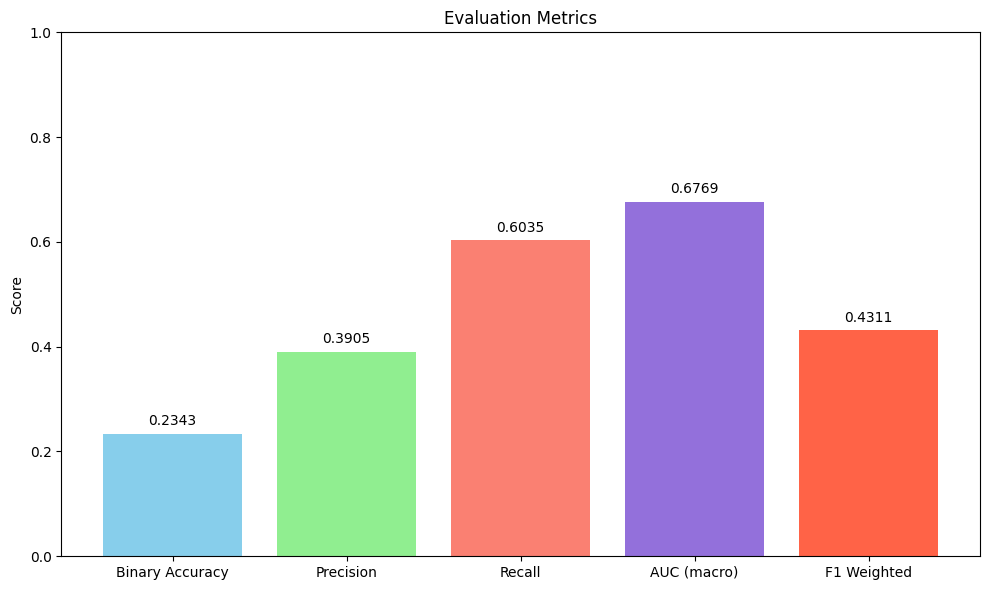

MlflowException: API request to https://dagshub.com/kristina.kogan/art-dna.mlflow/api/2.0/mlflow/runs/get failed with exception HTTPSConnectionPool(host='dagshub.com', port=443): Max retries exceeded with url: /kristina.kogan/art-dna.mlflow/api/2.0/mlflow/runs/get?run_uuid=b19dae92775e771542148a6cff8d3b48a8f1&run_id=b19dae92775e771542148a6cff8d3b48a8f1 (Caused by ResponseError('too many 500 error responses'))

In [ ]:
plot_metrics(
    val_binary_accuracy=val_binary_accuracy,
    val_precision=val_precision,
    val_recall=val_recall,
    val_auc=val_auc,
    f1_weighted_score=f1_weighted,
    filename="evaluation-metrics.png"
)
with mlflow.start_run(run_id="b19dae92775e771542148a6cff8d3b48a8f1"):
    mlflow.log_artifact("evaluation-metrics.png")

### 4.4 The overall confusion matrix

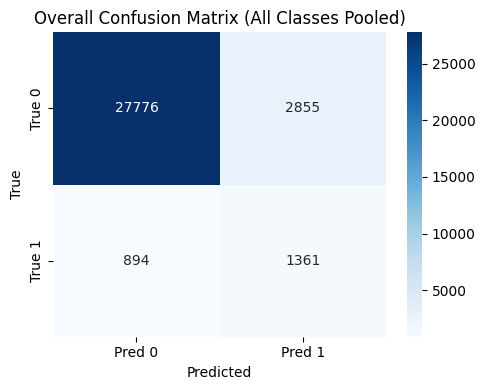

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

TP = FP = TN = FN = 0

for i in range(val_style_labels.shape[1]):  # For each class
    cm = confusion_matrix(val_style_labels[:, i], val_preds_opt[:, i])

    # Normalize edge cases where the confusion matrix isn't 2x2
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
        tp = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
        fn = cm[1, 0] if cm.shape[0] > 1 else 0
        fp = cm[0, 1] if cm.shape[1] > 1 else 0

    TP += tp
    TN += tn
    FP += fp
    FN += fn

# Construct pooled confusion matrix
pooled_cm = np.array([[TN, FP],
                      [FN, TP]])

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(pooled_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Overall Confusion Matrix (All Classes Pooled)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_overall.png")
plt.show()
plt.close()

#with mlflow.start_run(run_id=""):
    #mlflow.log_artifact("confusion_matrix_overall.png")

### 4.5 Confusion matrices per class

In [ ]:
print(COLUMN_LABELS.tolist())

['Abstractionism', 'Art Nouveau', 'Baroque', 'Byzantine Art', 'Cubism', 'Expressionism', 'Impressionism', 'Mannerism', 'Muralism', 'Neoplasticism', 'Pop Art', 'Primitivism', 'Realism', 'Renaissance', 'Romanticism', 'Suprematism', 'Surrealism', 'Symbolism']


In [ ]:
class_idx = print(COLUMN_LABELS.tolist().index("Impressionism"))

6


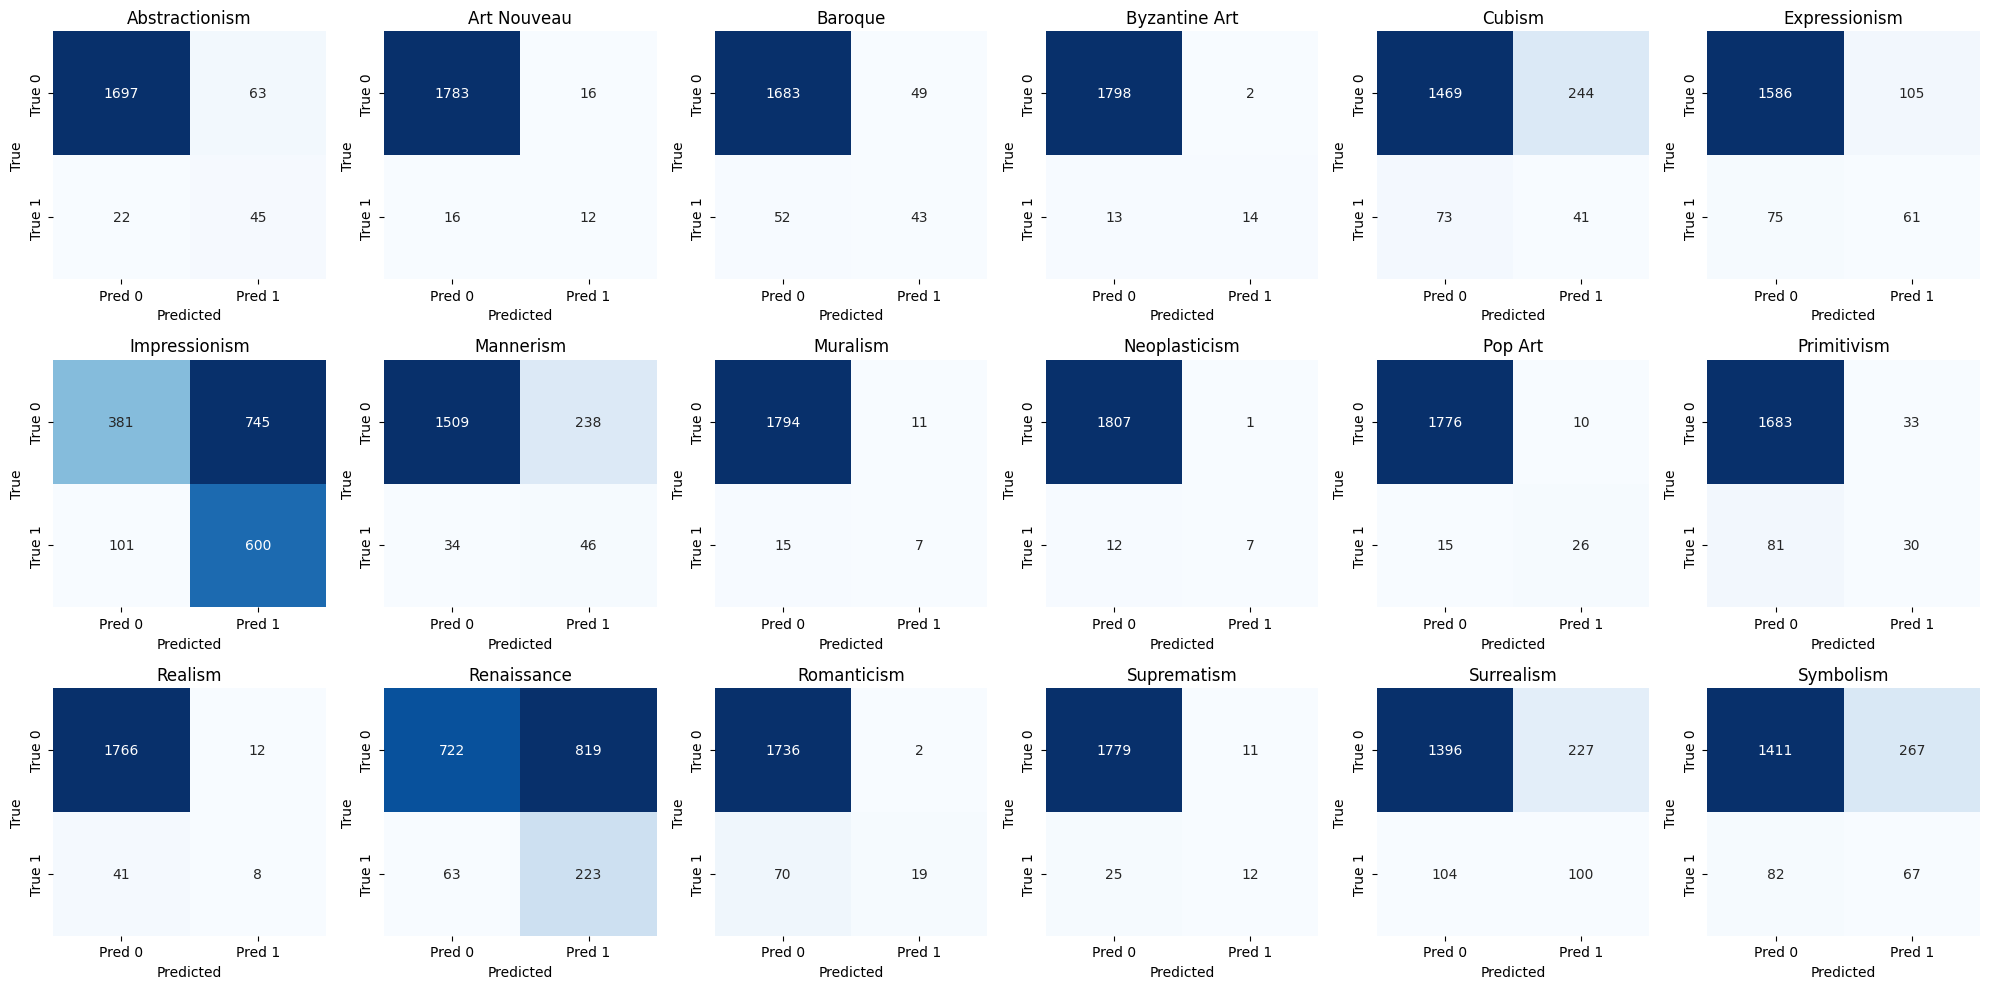

🏃 View run model_3_VGG16_v2 at: https://dagshub.com/kristina.kogan/art-dna.mlflow/#/experiments/0/runs/ae92775e771542148a6cff8d3b48a8f1
🧪 View experiment at: https://dagshub.com/kristina.kogan/art-dna.mlflow/#/experiments/0


In [ ]:
num_classes = len(COLUMN_LABELS)
rows, cols = 3, 6  # Adjust this grid to fit 18 classes nicely

fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.flatten()

for i in range(num_classes):
    y_true_class = val_style_labels[:, i]
    y_pred_class = val_preds_opt[:, i]
    cm = confusion_matrix(y_true_class, y_pred_class)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"],
                ax=axes[i])
    axes[i].set_title(COLUMN_LABELS[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# Remove any unused subplots if num_classes < rows*cols
for j in range(num_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# Save to file
plt.savefig("confusion-matrix-per-class-model-3.png")
plt.show()
plt.close()

with mlflow.start_run(run_id="ae92775e771542148a6cff8d3b48a8f1"):
    mlflow.log_artifact("confusion-matrix-per-class-model-3.png")

In [ ]:
#To stop the session
mlflow.end_run()